# Time Series Analysis and Forecasting with Prophet

 **Goal:** 

- Explore the data (ECDF, handle missing values etc).
- Analysis per store type and correlational analysis of stores activity.
- Perform extensive Time Series Analysis (seasonal decomposition, trends, autocorrelation).
- Predict next 6 weeks of sales using Prophet (Facebook methodology).

根据 https://www.kaggle.com/code/elenapetrova/time-series-analysis-and-forecasts-with-prophet/notebook 修改完成

---

In [2]:
import warnings
warnings.filterwarnings("ignore")

# loading packages
# basic + dates 
import numpy as np
import pandas as pd
from pandas import datetime

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns # advanced vizs
%matplotlib inline


# statistics
from statsmodels.distributions.empirical_distribution import ECDF

# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# prophet by Facebook
from fbprophet import Prophet

In [26]:
print("Joining train set with an additional transaction information.")

train = pd.read_csv("store-sales-time-series-forecasting/train.csv")
transaction = pd.read_csv("store-sales-time-series-forecasting/transactions.csv")

train = pd.merge(train, transaction, how = 'left', on = ['store_nbr', 'date'])

print("In total: ", train.shape)
train.head()

train.to_csv("store-sales-time-series-forecasting/train_with_transaction.csv", index = False)

Joining train set with an additional transaction information.
In total:  (3000888, 7)


In [31]:
train = pd.read_csv("store-sales-time-series-forecasting/train_with_transaction.csv")

print(train.head())

   id        date  store_nbr      family  sales  onpromotion  transactions
0   0  2013-01-01          1  AUTOMOTIVE    0.0            0           NaN
1   1  2013-01-01          1   BABY CARE    0.0            0           NaN
2   2  2013-01-01          1      BEAUTY    0.0            0           NaN
3   3  2013-01-01          1   BEVERAGES    0.0            0           NaN
4   4  2013-01-01          1       BOOKS    0.0            0           NaN


In [32]:


train.head()

,id,date,store_nbr,family,sales,onpromotion,transactions,transaction
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,NaN,0.0
1,1,2013-01-01,1,BABY CARE,0.0,0,NaN,0.0
2,2,2013-01-01,1,BEAUTY,0.0,0,NaN,0.0
3,3,2013-01-01,1,BEVERAGES,0.0,0,NaN,0.0
4,4,2013-01-01,1,BOOKS,0.0,0,NaN,0.0


In [34]:
# importing train data to learn
train = pd.read_csv("store-sales-time-series-forecasting/train_with_transaction.csv", 
                    parse_dates = True, low_memory = False, index_col = 'date')

train['transaction'] = train['transactions'].fillna(value=0)

# additional store data
store = pd.read_csv("store-sales-time-series-forecasting/stores.csv", 
                    low_memory = False)
# time series as indexes
train.index

DatetimeIndex(['2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01',
               ...
               '2017-08-15', '2017-08-15', '2017-08-15', '2017-08-15',
               '2017-08-15', '2017-08-15', '2017-08-15', '2017-08-15',
               '2017-08-15', '2017-08-15'],
              dtype='datetime64[ns]', name='date', length=3000888, freq=None)

## Exploratory Data Analysis 


首先检查train和store两个表，处理一下缺失值，做一些新的特征。

In [35]:
# first glance at the train set: head and tail
print("In total: ", train.shape)
train.head(5)

In total:  (3000888, 7)


,id,store_nbr,family,sales,onpromotion,transactions,transaction
date,,,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.0,0,NaN,0.0
2013-01-01,1,1,BABY CARE,0.0,0,NaN,0.0
2013-01-01,2,1,BEAUTY,0.0,0,NaN,0.0
2013-01-01,3,1,BEVERAGES,0.0,0,NaN,0.0
2013-01-01,4,1,BOOKS,0.0,0,NaN,0.0


In [36]:
# train的特征比较少，添加holiday的一些特征进去，先检查一下holiday
holiday_df = pd.read_csv("store-sales-time-series-forecasting/holidays_events.csv")
print(holiday_df.head())

         date     type    locale locale_name                    description  \
0  2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1  2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2  2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
3  2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
4  2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   

   transferred  
0        False  
1        False  
2        False  
3        False  
4        False  


可以用的：

date: 需要跟训练集做join

type: 如果是holiday，加进那个训练集

locale: national holiday in use，认为大部分商店会关门，如果是就写成1

In [37]:
# merge the holiday data with the train data
def get_holiday(date):
    try: 
        type = holiday_df[holiday_df.date == date].type.values[0]
        if( type == 'Holiday'):
        # if(holiday_df[holiday_df.date == date].locale.values[0] == 'Regional'):       #不确定要不要加这个，先试试
            return 1
        else:
            return 0
    except:
        return 0

holiday = []

train_df = pd.read_csv("store-sales-time-series-forecasting/train.csv")

for date in train_df.date:
    holiday.append(get_holiday(date))

train['holiday'] = holiday


In [47]:
train = train.drop('transactions', axis=1)
# 刚刚加错了

In [48]:
train[train.holiday == 0]
# 检查一下发现是有0的，成功

,id,store_nbr,family,sales,onpromotion,transaction,holiday
date,,,,,,,
2013-01-02,1782,1,AUTOMOTIVE,2.000,0,2111.0,0
2013-01-02,1783,1,BABY CARE,0.000,0,2111.0,0
2013-01-02,1784,1,BEAUTY,2.000,0,2111.0,0
2013-01-02,1785,1,BEVERAGES,1091.000,0,2111.0,0
2013-01-02,1786,1,BOOKS,0.000,0,2111.0,0
...,...,...,...,...,...,...,...
2017-08-14,2999101,9,POULTRY,283.429,0,1971.0,0
2017-08-14,2999102,9,PREPARED FOODS,114.120,0,1971.0,0
2017-08-14,2999103,9,PRODUCE,1348.425,7,1971.0,0


### ECDF: empirical cumulative distribution function

直观把握数据分布：

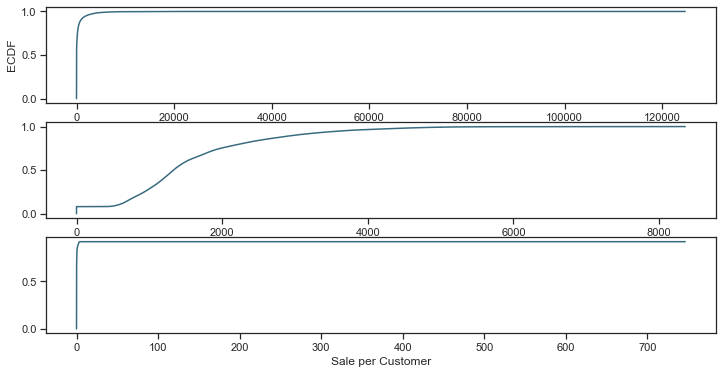

In [51]:
sns.set(style = "ticks")# to format into seaborn 
c = '#386B7F' # basic color for plots
plt.figure(figsize = (12, 6))

plt.subplot(311)
cdf = ECDF(train['sales'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Sales'); plt.ylabel('ECDF');

# plot second ECDF  
plt.subplot(312)
cdf = ECDF(train['transaction'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Customers');

# plot second ECDF  
plt.subplot(313)
cdf = ECDF(train['SalePerTransaction'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Sale per Customer');

### Missing values 
#### Closed stores and zero sales stores

In [52]:
nbr = 1
date = '2013-01-01'
train[(train.store_nbr == nbr) & (train.index == date)].sales.values

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
# closed stores
# train[(train.Open == 0) & (train.Sales == 0)].head()

# 首先，我们的数据集没有open项

open = []
true = [ 0 * i for i in range(len(train.store_nbr.unique()))]   # 最初都认为是关着的

# 假设从某个值开始都是0，就是closed
iter1 = list(train_df.date.unique())    # 坑：reverse（）返回值是none
iter2 = list(train.store_nbr.unique())
iter1.reverse()
iter2.reverse()
for date in iter1:          # 从后往前看，遇到首1认为是open, 否则认为是closed。
    for nbr in iter2:
        if(train[(train.store_nbr == nbr) & (train.index == date)].sales.values.any() != 0.0):
            # 坑3：這樣好像查不到value
            true[nbr - 1] = 1       # 坑2: 商店下标从1开始
            
        for i in range(33):         # 每天每个商店33种商品
            open.append(true[nbr - 1])

open.reverse()
train['open'] = open


# 但是怎么试好像全都是open的

In [75]:
train[train.open == 0].shape

(0, 11)

In [57]:
# missing values?
train.isnull().sum()
# 不会吧

id                         0
store_nbr                  0
family                     0
sales                      0
onpromotion                0
transaction                0
holiday                    0
year                       0
month                      0
day                        0
weekOfYear                 0
SalePerTransaction    242536
dtype: int64

In [63]:
train = pd.read_csv("store-sales-time-series-forecasting/train_store_transaction.csv",  low_memory = False)
train['SalePerTransaction'] = train['SalePerTransaction'].fillna(0)

What about store information:

In [53]:
# additional information about the stores
store.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


我们有的：

- store_nbr：
- type：A-E五种
- cluster：一会把在同一个cluster里的做成distance = 100， 不在同一个里的做成10000（看起来和上面的比较一个数量级）这个思路好像也不行
- promotion：在train里有，这里我们不plot了

In [60]:
# missing values?
store.isnull().sum()

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

不会吧，我们的数据集好到都没有missing value？

In [64]:
print("Joining train set with an additional store information.")

# by specifying inner join we make sure that only those observations 
# that are present in both train and store sets are merged together
# 啊还有这种写法？
train_store = pd.merge(train, store, how = 'inner', on = 'store_nbr')

print("In total: ", train_store.shape)
train_store.head()

Joining train set with an additional store information.
In total:  (3000888, 17)


,date,id,store_nbr,family,sales,onpromotion,transaction,holiday,year,month,day,weekOfYear,SalePerTransaction,city,state,type,cluster
0,2013-01-01,0,1,AUTOMOTIVE,0.0,0,0.0,1,2013,1,1,1,0.0,Quito,Pichincha,D,13
1,2013-01-01,1,1,BABY CARE,0.0,0,0.0,1,2013,1,1,1,0.0,Quito,Pichincha,D,13
2,2013-01-01,2,1,BEAUTY,0.0,0,0.0,1,2013,1,1,1,0.0,Quito,Pichincha,D,13
3,2013-01-01,3,1,BEVERAGES,0.0,0,0.0,1,2013,1,1,1,0.0,Quito,Pichincha,D,13
4,2013-01-01,4,1,BOOKS,0.0,0,0.0,1,2013,1,1,1,0.0,Quito,Pichincha,D,13


In [65]:
# 存好了！后面直接用……
train.to_csv("store-sales-time-series-forecasting/train_store_transaction.csv")

### Store types

In this section we will closely look at different levels of `StoreType` and how the main metric `Sales` is distributed among them.  

In [84]:
train_store.groupby('type')['sales'].describe()

,count,mean,std,min,25%,50%,75%,max
type,,,,,,,,
A,360904.0,978.220917,2167.495757,1.0000,17.0,139.000,806.9080,76090.000
B,296530.0,489.868260,1163.068586,0.1220,7.0,60.000,421.9975,89576.360
C,533821.0,308.033484,702.536015,0.7840,6.0,58.961,233.0000,45361.000
D,733451.0,478.673145,1100.372690,0.1460,10.0,86.000,372.0000,124717.000
E,137052.0,436.494439,931.277893,0.1923,7.0,83.000,333.0000,16542.902


`StoreType` A has the highest average of Sales among all others, however we have much less data for it. So let's print an overall sum of `Sales` and `Customers` to see which `StoreType` is the most selling and crowded one:


In [86]:
train_store.groupby('type')['transaction', 'sales'].sum()

,onpromotion,sales
type,,
A,1505180,3.530438e+08
B,1261812,1.452606e+08
C,1742255,1.644347e+08
D,2699181,3.510833e+08
E,601699,5.982244e+07


发现D是促销最多的

What about date periods? Seaborn's facet grid is the best tool for this task:



In [ ]:
# sales trends
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(dpi=100, figsize=(20, 8))
sns.factorplot(data = train_store, x = 'month', y = "sales", 
               col = 'type', # per store type in cols
               palette = 'plasma',
               hue = 'type',
               row = 'onpromotion', # per promo in the store in rows
               color = c) 

所有商店类型都遵循同样的趋势，但规模不同，这取决于（第一个）促销活动`促销`和`商店类型`本身（B的情况）的存在。

在这一点上，我们可以看到销售在圣诞假期前升级。但是我们将在后面的时间序列分析部分讨论季节性和趋势问题。

In [ ]:
# customers
sns.factorplot(data = train_store, x = 'month', y = "SalePerTransaction", 
               col = 'DayOfWeek', # per store type in cols
               palette = 'plasma',
               hue = 'type',
               row = 'type', # per store type in rows
               color = c) 

# 它说我的图太大了画不出来……一会再看吧

We see that stores of `StoreType` C are all closed on Sundays, whereas others are most of the time opened. Interestingly enough, stores of `StoreType` D are closed on Sundays only from October to December.

Bt the way what are the stores which are opened on Sundays?

In [ ]:
# stores which are opened on Sundays

train_tool = pd.read_csv("store-sales-time-series-forecasting/train.csv",  low_memory = False)

train['DayOfWeek'] = train_tool.date.dayofweek

train[train.DayOfWeek == 7]['store'].unique()

To complete our preliminary data analysis, we can add variables describing the period of time during which competition and promotion were opened:

The most selling and crowded `StoreType` A doesn't appear to be the one the most exposed to competitors. Instead it's a `StoreType` B, which also has the longest running period of promotion.

In [80]:
oil = pd.read_csv("store-sales-time-series-forecasting/oil.csv")
train = pd.read_csv("store-sales-time-series-forecasting/train_store_transaction.csv")

train = pd.merge(train, oil, how = 'left', on = ['date'])



In [85]:
train

,Unnamed: 0,date,id,store_nbr,family,sales,onpromotion,transaction,holiday,year,month,day,weekOfYear,SalePerTransaction,dcoilwtico
0,0,2013-01-01,0,1,AUTOMOTIVE,0.000,0,0.0,1,2013,1,1,1,0.000000,NaN
1,1,2013-01-01,1,1,BABY CARE,0.000,0,0.0,1,2013,1,1,1,0.000000,NaN
2,2,2013-01-01,2,1,BEAUTY,0.000,0,0.0,1,2013,1,1,1,0.000000,NaN
3,3,2013-01-01,3,1,BEVERAGES,0.000,0,0.0,1,2013,1,1,1,0.000000,NaN
4,4,2013-01-01,4,1,BOOKS,0.000,0,0.0,1,2013,1,1,1,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,3000883,9,POULTRY,438.133,0,2155.0,1,2017,8,15,33,0.203310,47.57
3000884,3000884,2017-08-15,3000884,9,PREPARED FOODS,154.553,1,2155.0,1,2017,8,15,33,0.071718,47.57
3000885,3000885,2017-08-15,3000885,9,PRODUCE,2419.729,148,2155.0,1,2017,8,15,33,1.122844,47.57
3000886,3000886,2017-08-15,3000886,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,2155.0,1,2017,8,15,33,0.056148,47.57


### Correlational Analysis

We are finished with adding new variables to the data, so now we can check the overall correlations by plotting the `seaborn` heatmap:

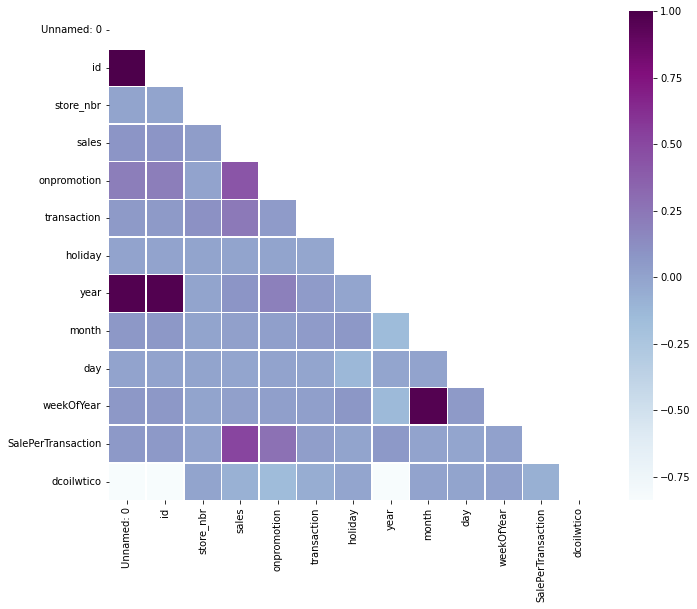

In [83]:
# Compute the correlation matrix 
# exclude 'Open' variable
corr_all = train.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_all, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_all, mask = mask,
            square = True, linewidths = .5, ax = ax, cmap = "BuPu")      
plt.show()

In [89]:
# sale per customer trends
sns.factorplot(data = train, x = 'weekOfYear', y = "sales", 
               col = 'onpromotion', 
               row = 'transaction',
               hue = 'transaction',
               palette = 'RdPu') 

: 

: 

## Time-Series Analysis per Store Type

是什么使时间序列与普通的回归问题不同？

- 它是与时间相关的。在这种情况下，线性回归的基本假设，即观测值是独立的，并不成立。
- 除了增加或减少的趋势，大多数时间序列都有某种形式的季节性趋势，即特定时间范围内的变化。例如，对于圣诞假期，我们将在这个数据集中看到。

我们建立了一个关于商店类型而不是单个商店的时间序列分析。这种方法的主要优势在于其简单的表现形式和对数据集中不同趋势和季节性的整体考虑。 

在本节中，我们将分析时间序列数据：其趋势、季节性和自相关。通常在分析的最后，我们能够建立一个季节性的ARIMA（自回归综合移动平均）模型，但这不是我们今天的主要重点。相反，我们试图理解数据，然后才用先知的方法得出预测的结果。


### Seasonality

<AxesSubplot:xlabel='date'>

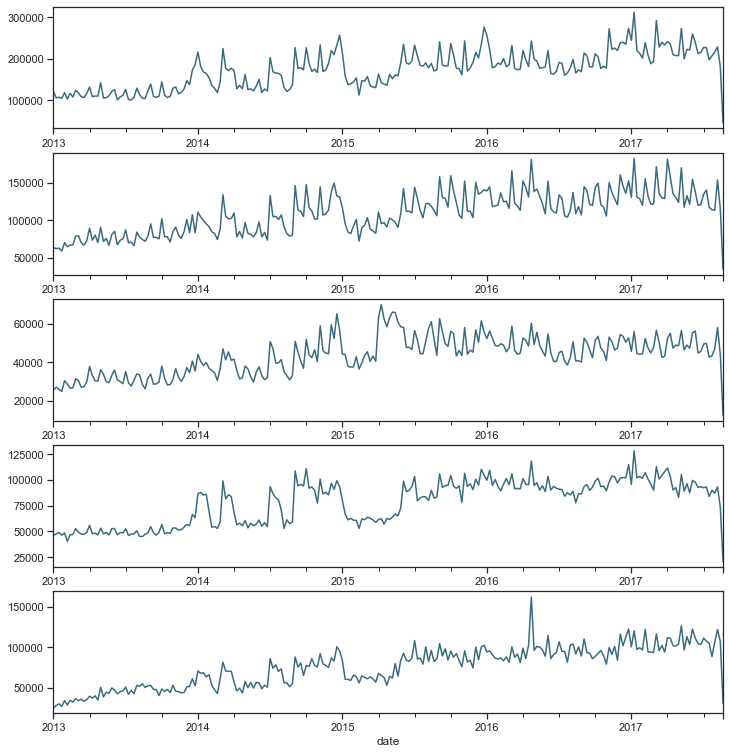

In [77]:
# 分别选择各类中的一个商店看看
train = pd.read_csv("store-sales-time-series-forecasting/train_store_transaction.csv", 
                    parse_dates = True, low_memory = False, index_col = 'date')

# preparation: input should be float type
# 好聪明的写法
train['sales'] = train['sales'] * 1.0

# store types
sales_a = train[train.store_nbr == 46]['sales']
sales_b = train[train.store_nbr == 9]['sales'].sort_index(ascending = True) # solve the reverse order
sales_c = train[train.store_nbr == 13]['sales']
sales_d = train[train.store_nbr == 4]['sales']
sales_e = train[train.store_nbr == 28]['sales']

f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, figsize = (12, 13))

# store type
sales_a.resample('W').sum().plot(color = c, ax = ax1)
sales_b.resample('W').sum().plot(color = c, ax = ax2)
sales_c.resample('W').sum().plot(color = c, ax = ax3)
sales_d.resample('W').sum().plot(color = c, ax = ax4)
sales_e.resample('W').sum().plot(color = c, ax = ax5)

### Yearly trend

The next thing to check the presence of a trend in series.

<AxesSubplot:xlabel='date'>

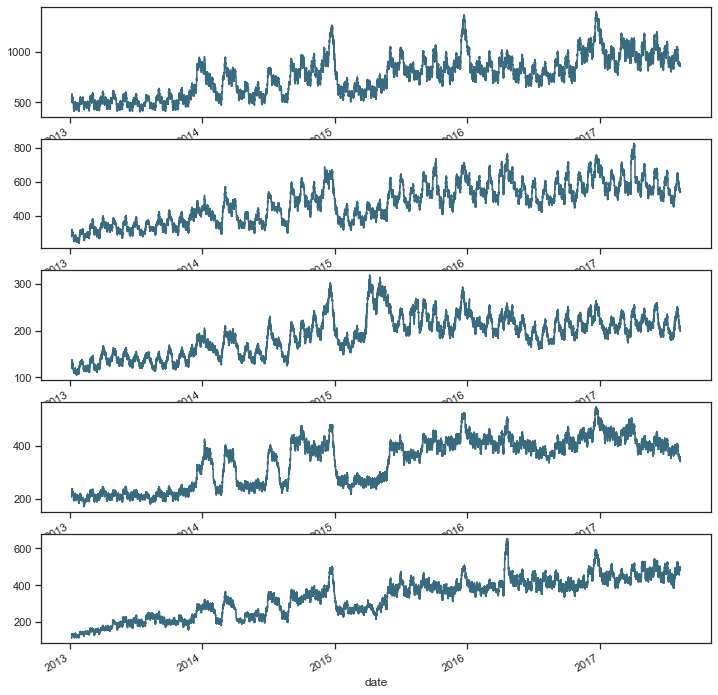

In [78]:
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, figsize = (12, 13))

# monthly
decomposition_a = seasonal_decompose(sales_a, model = 'additive', freq = 365)
decomposition_a.trend.plot(color = c, ax = ax1)

decomposition_b = seasonal_decompose(sales_b, model = 'additive', freq = 365)
decomposition_b.trend.plot(color = c, ax = ax2)

decomposition_c = seasonal_decompose(sales_c, model = 'additive', freq = 365)
decomposition_c.trend.plot(color = c, ax = ax3)

decomposition_d = seasonal_decompose(sales_d, model = 'additive', freq = 365)
decomposition_d.trend.plot(color = c, ax = ax4)

decomposition_e = seasonal_decompose(sales_e, model = 'additive', freq = 365)
decomposition_e.trend.plot(color = c, ax = ax5)

### Autocorrelaion

我们时间序列分析的下一步是审查自相关函数（ACF）和部分自相关函数（PACF）图。

ACF是对时间序列与自身的滞后版本之间的相关性的衡量。例如，在滞后5年时，ACF将比较瞬间't1'...'tn'的系列与瞬间't1-5'...'tn-5'的系列（t1-5和tn是终点）。

另一方面，PACF测量时间序列与自身的滞后版本之间的相关性，但在消除了中间的比较所解释的变化之后。例如，在滞后5期，它将检查相关性，但消除已经由滞后1至4期解释的影响。

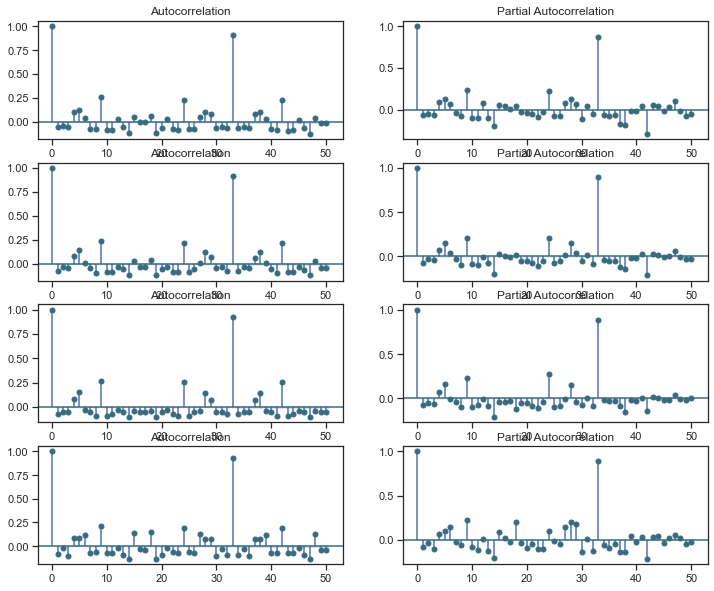

In [90]:
# figure for subplots
plt.figure(figsize = (12, 10))

# acf and pacf for A
plt.subplot(421); plot_acf(sales_a, lags = 50, ax = plt.gca(), color = c)
plt.subplot(422); plot_pacf(sales_a, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for B
plt.subplot(423); plot_acf(sales_b, lags = 50, ax = plt.gca(), color = c)
plt.subplot(424); plot_pacf(sales_b, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for C
plt.subplot(425); plot_acf(sales_c, lags = 50, ax = plt.gca(), color = c)
plt.subplot(426); plot_pacf(sales_c, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for D
plt.subplot(427); plot_acf(sales_d, lags = 50, ax = plt.gca(), color = c)
plt.subplot(428); plot_pacf(sales_d, lags = 50, ax = plt.gca(), color = c)


plt.show()

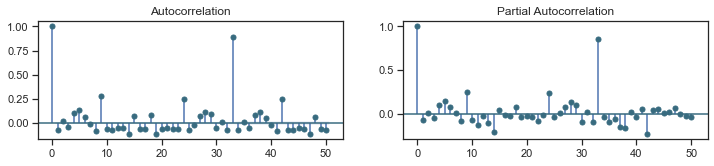

In [92]:
# figure for subplots
plt.figure(figsize = (12, 10))

# acf and pacf for E
plt.subplot(421); plot_acf(sales_e, lags = 50, ax = plt.gca(), color = c)
plt.subplot(422); plot_pacf(sales_e, lags = 50, ax = plt.gca(), color = c)


plt.show()

## Time Series Analysis and Forecasting with Prophet
#### Forecasting for the next 6 weeks for the first store

我们只需要16天就可以了？

In [25]:
# importing data
df = pd.read_csv("store-sales-time-series-forecasting/train_store_transaction.csv",  low_memory = False)

# remove closed stores and those with no sales
# df = df[df['sales'] != 0]

# sales for the store number 1 (StoreType C)
sales = df[df.store_nbr == 1].loc[:, ['date', 'sales']]

# reverse to the order: from 2013 to 2015
sales = sales.sort_index(ascending = False)

# to datetime64
sales['date'] = pd.DatetimeIndex(sales['date'])
sales.dtypes

date     datetime64[ns]
sales           float64
dtype: object

In [26]:
# from the prophet documentation every variables should have specific names
sales = sales.rename(columns = {'date': 'ds',
                                'sales': 'y'})
sales.head()

,ds,y
2999138,2017-08-15,22.487000
2999137,2017-08-15,0.000000
2999136,2017-08-15,2240.230000
2999135,2017-08-15,42.822998
2999134,2017-08-15,234.892000


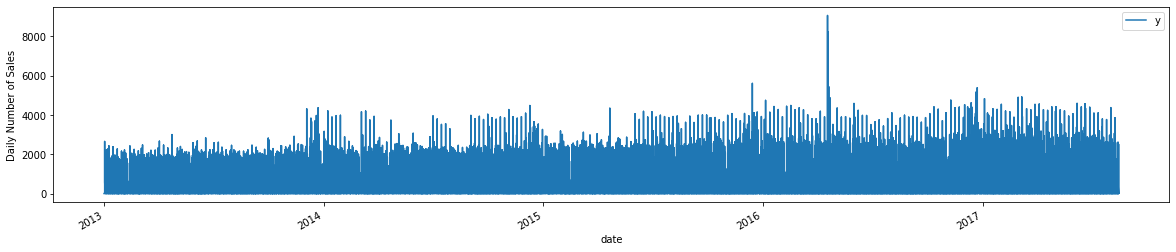

In [27]:
# plot daily sales
ax = sales.set_index('ds').plot(figsize = (20, 4))
ax.set_ylabel('Daily Number of Sales')
ax.set_xlabel('date')
plt.show()
#


### Modeling Holidays

Prophet also allows to [model for holidays](https://facebookincubator.github.io/prophet/docs/holiday_effects.html), and that's what we do here.

数据集中的StateHoliday变量表示一个州的假日，在这个假日所有的商店通常都会关门。数据集中还有学校假期，在这些假期中，某些商店也会关门。


In [28]:
holiday_df = pd.read_csv("store-sales-time-series-forecasting/holidays_events.csv")
holiday_df.head()

# 整一个跟上面一样的ds
state = []
for date in holiday_df.date:
    try:
        type = holiday_df[holiday_df.date == date].type
        locale = holiday_df[holiday_df.date == date].locale
        if((type.any() == 'Holiday') and (locale.any() == 'Regional')):
            state.append('state_holiday')
        else:
            state.append('not_holiday')
    except:
        state.append('not_holiday')

holiday_df['holiday'] = state

In [29]:
holidays = holiday_df[holiday_df.holiday == 'state_holiday']
holidays = holidays.drop(['type', 'locale', 'locale_name', 'description', 'transferred'], axis = 1)
holidays.head()

,date,holiday
1,2012-04-01,state_holiday
7,2012-06-25,state_holiday
8,2012-06-25,state_holiday
9,2012-06-25,state_holiday
23,2012-11-06,state_holiday


In [30]:
holidays = holidays.rename(columns={'date': 'ds'})
holidays.head()

,ds,holiday
1,2012-04-01,state_holiday
7,2012-06-25,state_holiday
8,2012-06-25,state_holiday
9,2012-06-25,state_holiday
23,2012-11-06,state_holiday


In [31]:
test = pd.read_csv("store-sales-time-series-forecasting/test.csv", low_memory = False)
test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [32]:
my_submission = pd.read_csv("store-sales-time-series-forecasting/sample_submission.csv", low_memory = False)

# 只与test的id是关联的

In [ ]:
my_model = Prophet(interval_width = 0.95, holidays = holidays, daily_seasonality=True)
my_model.fit(sales)

future_dates = my_model.make_future_dataframe(periods = 6*7)

future_dates

In [34]:
test['prediction'] = [0]*len(test)
test

,id,date,store_nbr,family,onpromotion,prediction
0,3000888,2017-08-16,1,AUTOMOTIVE,0,0
1,3000889,2017-08-16,1,BABY CARE,0,0
2,3000890,2017-08-16,1,BEAUTY,2,0
3,3000891,2017-08-16,1,BEVERAGES,20,0
4,3000892,2017-08-16,1,BOOKS,0,0
...,...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1,0
28508,3029396,2017-08-31,9,PREPARED FOODS,0,0
28509,3029397,2017-08-31,9,PRODUCE,1,0
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9,0


In [15]:
test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [35]:
# 需要分成33个family来预测
for good in df.family.unique():
    # 应该是共33轮，我们直接每次把family取成一个新的df
    for store_nbr in df.store_nbr.unique():
        # 每个family中每个store_nbr取成一个新的sales
        sales = df[(df.store_nbr == store_nbr) & (df.family == good)].loc[:, ['date', 'sales']]
        # reverse to the order: from 2013 to 2015
        sales = sales.sort_index(ascending=False)
        # to datetime64
        sales['date'] = pd.DatetimeIndex(sales['date'])
        sales = sales.rename(columns={'date': 'ds', 'sales': 'y'})
        # set the uncertainty interval to 95% (the Prophet default is 80%)
        try:
            my_model = Prophet(interval_width=0.95,
                            holidays=holidays, daily_seasonality=True, yearly_seasonality=True, weekly_seasonality=True)
            my_model.fit(sales)
            future_dates = pd.DataFrame(test.date.unique(), columns=['ds'])
            # future_dates = future_dates.rename(columns = {0: 'ds'})
            # print(future_dates)
            forecast = my_model.predict(future_dates)
            fc = forecast[['ds', 'yhat']].rename(
                columns={'date': 'ds', 'forecast': 'yhat'})
            goodname = good.replace('/', '-')
            fc.to_csv('fc/forecast_' + str(goodname) + '_' + str(store_nbr) + '.csv')
            # merge with the test data
            # 相等值要有3个：date, store_nbr, family
            df['date'] = df['date'].astype(str)
            fc['ds'] = fc['ds'].astype(str)
            for ds in fc.ds:
                test[((test.date == str(ds)) & (test.store_nbr == str(store_nbr)))
                    & (test.family == str(good))].prediction = fc[fc.ds == ds].yhat
        except:
            print(store_nbr, good)
test.head()

,id,date,store_nbr,family,onpromotion,prediction
0,3000888,2017-08-16,1,AUTOMOTIVE,0,0
1,3000889,2017-08-16,1,BABY CARE,0,0
2,3000890,2017-08-16,1,BEAUTY,2,0
3,3000891,2017-08-16,1,BEVERAGES,20,0
4,3000892,2017-08-16,1,BOOKS,0,0


In [40]:
len(df.family.unique()) * len(df.store_nbr.unique())

1782

In [51]:
# 晚上想办法把这个这样读进去吧，别的方法看来不太行
prediction = [0] * len(test)
# 做一个新的prediction dataframe(含date，family，nbr)然后拼进去。再跟submission拼一下

pre = {
    'ds': [],
    'family': [],
    'store_nbr': [],
    'prediction': []
}
pre

{'ds': [], 'family': [], 'store_nbr': [], 'prediction': []}

In [ ]:
import os
for file in os.listdir('fc'):
    file = file.split("_")
    file[2] = file[2].strip(".csv")
    print(file)
    df = pd.read_csv('fc/' + file[0] + '_' + file[1] + '_' + file[2] + '.csv')
    file[1] = file[1].replace('-', '/')
    for row in df.itertuples():
        pre['ds'].append(getattr(row, "ds"))
        pre['family'].append(file[1])
        pre['store_nbr'].append(file[2])
        pre['prediction'].append(getattr(row, "yhat"))

pre


In [55]:
prediction = pd.DataFrame(pre)
prediction

,ds,family,store_nbr,prediction
0,2017-08-16,PLAYERS AND ELECTRONICS,46,42.378574
1,2017-08-17,PLAYERS AND ELECTRONICS,46,41.283679
2,2017-08-18,PLAYERS AND ELECTRONICS,46,43.188559
3,2017-08-19,PLAYERS AND ELECTRONICS,46,53.578544
4,2017-08-20,PLAYERS AND ELECTRONICS,46,57.810559
...,...,...,...,...
28763,2017-08-27,DAIRY,45,3473.641685
28764,2017-08-28,DAIRY,45,2390.747635
28765,2017-08-29,DAIRY,45,2093.458269
28766,2017-08-30,DAIRY,45,2279.545740


In [58]:
test = test.rename(columns={'date': 'ds'})
test.head()

,id,ds,store_nbr,family,onpromotion,prediction
0,3000888,2017-08-16,1,AUTOMOTIVE,0,0
1,3000889,2017-08-16,1,BABY CARE,0,0
2,3000890,2017-08-16,1,BEAUTY,2,0
3,3000891,2017-08-16,1,BEVERAGES,20,0
4,3000892,2017-08-16,1,BOOKS,0,0


In [73]:
print("Joining train set with an additional store information.")

# by specifying inner join we make sure that only those observations 
# that are present in both train and store sets are merged together
# 啊还有这种写法？
test['ds']=test['ds'].astype(str)
test['family']=test['family'].astype(str)
test['store_nbr']=test['store_nbr'].astype(str)
prediction['ds']=prediction['ds'].astype(str)
prediction['family']=prediction['family'].astype(str)
prediction['store_nbr']=prediction['store_nbr'].astype(str)

result = pd.merge(test, prediction, how = 'left', on = ['ds', 'family', 'store_nbr'])

print("In total: ", result.shape)
result.head()

Joining train set with an additional store information.
In total:  (28768, 7)


,id,ds,store_nbr,family,onpromotion,prediction_x,prediction_y
0,3000888,2017-08-16,1,AUTOMOTIVE,0,0,4.368214
1,3000889,2017-08-16,1,BABY CARE,0,0,0.000000
2,3000890,2017-08-16,1,BEAUTY,2,0,3.784480
3,3000891,2017-08-16,1,BEVERAGES,20,0,2280.357274
4,3000892,2017-08-16,1,BOOKS,0,0,0.478608


In [77]:
result_new = result_new.drop_duplicates(subset=['id'], keep='first')
result_new

,id,sales_x,sales_y,sales_x,sales_y
0,3000888,4.368214,0.0,0.0,0.0
1,3000889,0.000000,0.0,0.0,0.0
2,3000890,3.784480,0.0,0.0,0.0
3,3000891,2280.357274,0.0,0.0,0.0
4,3000892,0.478608,0.0,0.0,0.0
...,...,...,...,...,...
28763,3029395,373.437491,0.0,0.0,0.0
28764,3029396,116.273855,0.0,0.0,0.0
28765,3029397,1629.237615,0.0,0.0,0.0
28766,3029398,54.787603,0.0,0.0,0.0


In [61]:
result_new = result.drop('ds', axis=1)
result_new = result_new.drop('store_nbr', axis=1)
result_new = result_new.drop('family', axis=1)
result_new = result_new.drop('onpromotion', axis=1)
result_new = result_new.drop('prediction_x', axis=1)
result_new = result_new.rename(columns={'prediction_y': 'sales'})

result_new

,id,sales
0,3000888,4.368214
1,3000889,0.000000
2,3000890,3.784480
3,3000891,2280.357274
4,3000892,0.478608
...,...,...
28763,3029395,373.437491
28764,3029396,116.273855
28765,3029397,1629.237615
28766,3029398,54.787603


In [63]:
sample_submission = pd.read_csv('store-sales-time-series-forecasting/sample_submission.csv')
sample_submission

,id,sales
0,3000888,0.0
1,3000889,0.0
2,3000890,0.0
3,3000891,0.0
4,3000892,0.0
...,...,...
28507,3029395,0.0
28508,3029396,0.0
28509,3029397,0.0
28510,3029398,0.0


In [67]:
result_new = pd.merge(result_new, sample_submission, how = 'inner', on = ['id'])
result_new

,id,sales_x,sales_y,sales_x,sales_y
0,3000888,4.368214,0.0,0.0,0.0
1,3000889,0.000000,0.0,0.0,0.0
2,3000890,3.784480,0.0,0.0,0.0
3,3000891,2280.357274,0.0,0.0,0.0
4,3000892,0.478608,0.0,0.0,0.0
...,...,...,...,...,...
28763,3029395,373.437491,0.0,0.0,0.0
28764,3029396,116.273855,0.0,0.0,0.0
28765,3029397,1629.237615,0.0,0.0,0.0
28766,3029398,54.787603,0.0,0.0,0.0


In [78]:
result_new.to_csv("submission5.csv", index=False)

In [128]:
# predictions
forecast = my_model.predict(future_dates)

# preditions for last week
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100)



,ds,yhat,yhat_lower,yhat_upper
1620,2017-06-19,388.895615,-911.458743,1695.947772
1621,2017-06-20,381.199716,-958.116185,1617.904970
1622,2017-06-21,462.089687,-886.764286,1756.990294
1623,2017-06-22,365.068743,-941.805966,1644.281111
1624,2017-06-23,414.265916,-759.675952,1695.554041
...,...,...,...,...
1715,2017-09-22,409.879875,-797.135003,1675.497634
1716,2017-09-23,384.399908,-930.884117,1636.312326
1717,2017-09-24,207.466210,-1066.392525,1503.505270
1718,2017-09-25,385.905515,-873.633050,1658.550075


The forecast object here is a new dataframe that includes a column yhat with the forecast, as well as columns for components and uncertainty intervals.

In [118]:
fc = forecast[['ds', 'yhat']].rename(columns = {'Date': 'ds', 'Forecast': 'yhat'})

Prophet 绘制时间序列的观察值（黑点），预测值（蓝线）和预测的不确定性区间（蓝色阴影区域）。

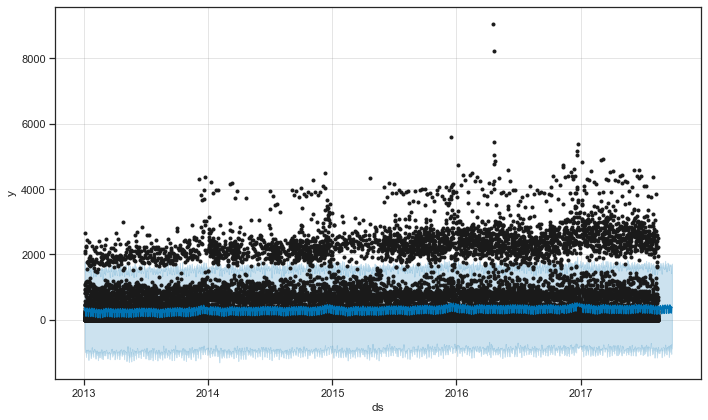

In [121]:
# visualizing predicions
my_model.plot(forecast);

#怎么看着这么奇怪啊

Prophet的另一个特别强大的功能是它能够返回我们预测的组成部分。这可以帮助揭示时间序列的日、周和年模式以及许多包括在其中的假期对整体预测值的贡献。

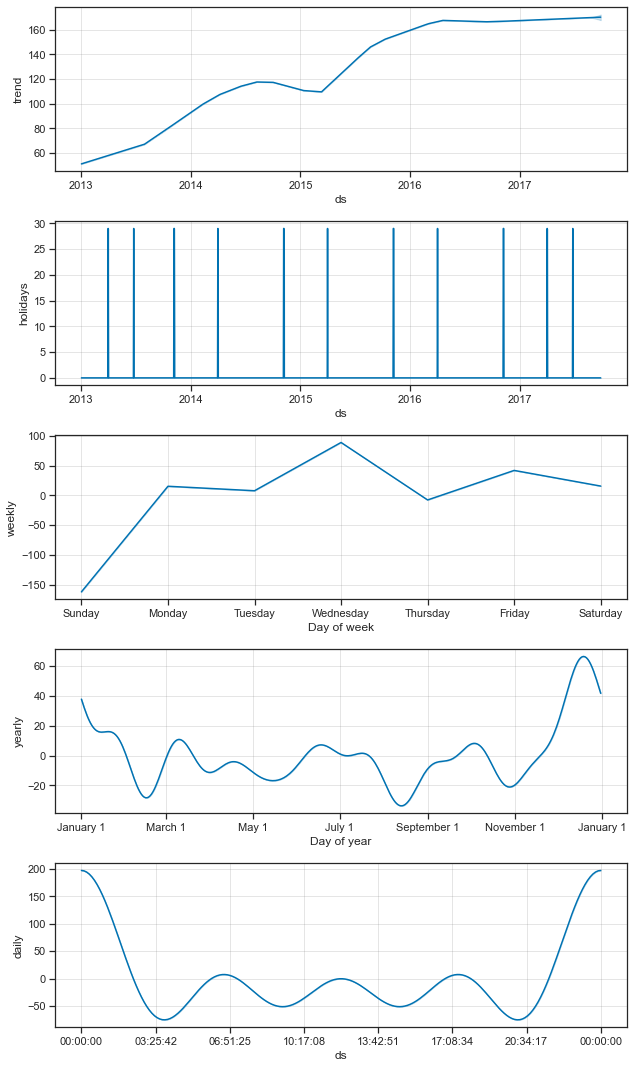

In [122]:
my_model.plot_components(forecast);

#这里的最后一幅图日是不对的，0点高是因为时间戳没有精细到小时，所有时间戳都标记为0点

最繁忙的季节发生在圣诞节期间。